<div id=top></div>

# Reinforcement Learning with Doom - Increasing complexity and monitoring the model

Leandro Kieliger
contact@lkieliger.ch

---
## Description

In this notebook we are going to build upon the setup introduced in the previous part of this series. We will tackle a more difficult scenario, add useful logging to the learning process and finally start competing against in-game bots in a first attemps at playing a deathmatch game using reinforcement learning.

The notebook is structured in 3 parts:


### [Part 1 - Increasing complexity](#part_1)
* [Defend the center](#defend_the_center)
* [Defend the center (harder)](#defend_the_center_hard)

    
### [Part 2 - Monitoring the model](#part_2)
* [Adding hooks](#monitoring)
* [Monitoring callback](#callback)
* [Adding normalization](#normalization)
* [Comparing norms](#norm_comparison)
    
    
### [Part 3 - Playing doom deathmatch](#part_3)
* [Scenario presentation](#deathmatch_presentation)
* [New environment](#deathmatch_environment)
* [Discussion](#deathmatch_discussion)

<div id=part_1></div>

# [^](#top) Part 1 - Increasing complexity


## Preparations

In [7]:
%load_ext autoreload
%autoreload 2

import cv2
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import typing as t
import vizdoom
from stable_baselines3 import ppo
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common import evaluation, policies
from torch import nn

from common import envs, plotting

<div id=defend_the_center></div>

## New scenario: Defend The Center

The next scenario we are going to tackle is called "Defend the center". In this scenario, the agent is stuck in the center of a circular arena and will be attacked by monsters spawning at random intervals and locations. Here are the rewards for this scenario:

* 1 point for each ennemy killed.
* -1 point for dying.

Since there is a limit on the total ammunition of the agent, 26, the theoretical maximum reward achievable for this scenario is 25. The buttons available are `ATTACK`, `TURN_LEFT` and `TURN_RIGHT`. 

We are going to define a little helper function that will streamline the training and evaluation process as we will need to repeat it several time in this notebook. The function simply create the environments, instantiate an agent based on the PPO algorithm and start training and optionally evaluating the agent for a given number of steps.

In [44]:
def solve_env(env_args, agent_args, n_envs, timesteps, callbacks, eval_freq=None, init_func=None):
    """Helper function to streamline the learning and evaluation process.
    
    Args:
         env_args:    A dict containing arguments passed to the environment.
         agent_args:  A dict containing arguments passed to the agent.
         n_envs:      The number of parallel training envs to instantiate.
         timesteps:   The number of timesteps for which to train the model.
         callbacks:   A list of callbacks for the training process.
         eval_freq:   The frequency (in steps) at which to evaluate the agent.
         init_func:   A function to be applied on the agent before training.
    """
    # Create environments.
    env = envs.create_vec_env(n_envs, **env_args)

    # Build the agent.
    agent = ppo.PPO(policies.ActorCriticCnnPolicy, env, tensorboard_log='logs/tensorboard', seed=0, **agent_args)
    
    # Optional processing on the agent.
    if init_func is not None: 
        init_func(agent)
        
    # Optional evaluation callback.
    if eval_freq is not None:
        eval_env = envs.create_eval_vec_env(**env_args)

        callbacks.append(EvalCallback(
            eval_env, 
            n_eval_episodes=10, 
            eval_freq=eval_freq, 
            log_path=f'logs/evaluations/{env_args["scenario"]}'
            best_model_save_path=f'logs/models/{env_args["scenario"]}'))

    # Start the training process.
    agent.learn(total_timesteps=timesteps, tb_log_name=env_args['scenario'], callback=callbacks)

    # Cleanup.
    env.close()
    if eval_freq is not None: eval_env.close()
    
    return agent

Next, we configure the environments like we have seen in the [previous notebook](https://github.com/lkiel/rl-doom/blob/develop/standalone_examples/Basic%20Scenario.ipynb). We will be training for only 100k steps as this is already enough to reach a good score in this scenario. Don't forget to specify the frame skip parameter as we have seen that this is one of the most efficient way to speed up the learning process along with the learning rate.

In [7]:
# Results in a 100x156 image, no pixel lost due to padding with the default CNN architecture
frame_processor = lambda frame: cv2.resize(frame[40:, 4:-4], None, fx=.5, fy=.5, interpolation=cv2.INTER_AREA)

In [ ]:
env_args = {'scenario': 'defend_the_center', 'frame_skip': 4, 'frame_processor': frame_processor}
agent_args = {'n_epochs': 3, 'n_steps': 1024, 'learning_rate': 1e-4, 'batch_size': 32}

solve_env(env_args, agent_args, n_envs=2, timesteps=100000, callbacks=[], eval_freq=2048)

We see that very quickly we reach satisfactory results. This is not surprising since the scenario is not much more difficult than the basic one we have seen in the previous notebook. Let's try to add some complexity.

<div id=defend_the_center_hard></div>

# Defend the center (difficult version)


Remember that our ultimate goal is to train an agent to play Doom deathmatch against bots. We will use the scenario we just solved as a good middle ground to perform some experiments before jumping to the more difficult task of playing against bots. **In general, it is often a good idea to start simple and progressively add complexity to the task.**

The increased complexity here will arise from the fact that in a deathmatch environment, we will need to perform more actions than simply turning around and shooting. Here is the list of buttons we will be using:

```
ATTACK, TURN_LEFT, TURN_RIGHT, MOVE_FORWARD, MOVE_LEFT, MOVE_RIGHT
```

A simple solution would be to directly add more buttons to the config file. Although this will work, you will notice that the agent will be quite slow in the sense that he can only perform one action at a time. Either shoot, turn or move. Although this is not a big issue in the current scenario, when playing later against bots running all over the place our agent will be unfairly disadvantaged because of the limitations in its actions.

![Agent 6 outputs](figures/deathmatch_agent_out=6.gif)

VizDoom allows us to provide a list of button states but our model uses a discrete action space. A simple workaround is to generate all possible combination of buttons and use each combination as a single action. However, the number of such possible combination is $2^n$ where $n$ is the number of available buttons. Even is our simple case with only 6 buttons, this would mean having 64 possible outputs. To mitigate the combinatorial explosion of our action space, we are going to forbid certain combination. Indeed, it does not make much sense to allow for example both `TURN_RIGHT` and `TURN_LEFT` to be activated at the same time. Therefore, we will remove the following combinations:

* `TURN_RIGHT` and `TURN_LEFT`
* `MOVE_RIGHT` and `MOVE_LEFT`

And we will also only allow the `ATTACK` button to be used alone. This will not hurt performance as most weapons in Doom have a cooldown period between two attacks anyway. In the end, the total number of different possible actions is given by the cartesian product of:

```
{ATTACK} + {TURN_RIGHT, TURN_LEFT, NOTHING} x {MOVE_RIGHT, MOVE_LEFT, NOTHING} x {MOVE_FORWARD, NOTHING}

```
Since we don't want the all-zero state (no button pressed) this will give us a grand total of 18 which is much better than the 64 we could have ended up with. Here is the code to generate the action space given a list of buttons and our exclusion lists.

In [8]:
import itertools
import typing as t

from vizdoom import Button


# Buttons that cannot be used together
MUTUALLY_EXCLUSIVE_GROUPS = [
    [Button.MOVE_RIGHT, Button.MOVE_LEFT],
    [Button.TURN_RIGHT, Button.TURN_LEFT],
    [Button.MOVE_FORWARD, Button.MOVE_BACKWARD],
]

# Buttons that can only be used alone.
EXCLUSIVE_BUTTONS = [Button.ATTACK]


def has_exclusive_button(actions: np.ndarray, buttons: np.array) -> np.array:
    exclusion_mask = np.isin(buttons, EXCLUSIVE_BUTTONS)
    
    # Flag actions that have more than 1 active button among exclusive list.
    return (np.any(actions.astype(bool) & exclusion_mask, axis=-1)) & (np.sum(actions, axis=-1) > 1)


def has_excluded_pair(actions: np.ndarray, buttons: np.array) -> np.array:
    # Create mask of shape (n_mutual_exclusion_groups, n_available_buttons), marking location of excluded pairs.
    mutual_exclusion_mask = np.array([np.isin(buttons, excluded_group) 
                                      for excluded_group in MUTUALLY_EXCLUSIVE_GROUPS])

    # Flag actions that have more than 1 button active in any of the mutual exclusion groups.
    return np.any(np.sum(
        # Resulting shape (n_actions, n_mutual_exclusion_groups, n_available_buttons)
        (actions[:, np.newaxis, :] * mutual_exclusion_mask.astype(int)),
        axis=-1) > 1, axis=-1)


def get_available_actions(buttons: np.array) -> t.List[t.List[float]]:
    # Create list of all possible actions of size (2^n_available_buttons x n_available_buttons)
    action_combinations = np.array([list(seq) for seq in itertools.product([0., 1.], repeat=len(buttons))])

    # Build action mask from action combinations and exclusion mask
    illegal_mask = (has_excluded_pair(action_combinations, buttons)
                    | has_exclusive_button(action_combinations, buttons))

    possible_actions = action_combinations[~illegal_mask]
    possible_actions = possible_actions[np.sum(possible_actions, axis=1) > 0]  # Remove no-op

    print('Built action space of size {} from buttons {}'.format(len(possible_actions), buttons))
    return possible_actions.tolist()

possible_actions = get_available_actions(np.array([
    Button.ATTACK, Button.MOVE_FORWARD, Button.MOVE_LEFT, 
    Button.MOVE_RIGHT, Button.TURN_LEFT, Button.TURN_RIGHT]))

possible_actions

Built action space of size 18 from buttons [<Button.ATTACK: 0> <Button.MOVE_FORWARD: 13> <Button.MOVE_LEFT: 11>
 <Button.MOVE_RIGHT: 10> <Button.TURN_LEFT: 15> <Button.TURN_RIGHT: 14>]


[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 1.0, 1.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 [0.0, 1.0, 0.0, 1.0, 1.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 1.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

Here is what a trained agent the uses the modified 18-output version navigate across the map. It looks much more dynamic and we can expect better results when competing in a deathmatch.

![Agent 18 outputs](figures/deathmatch_agent_out=18.gif)

Training the model in this more challenging environment will definitely require more training time. This is a good opportunity to log some metrics to help us monitor the training process.

<div id=part_2></div>

# [^](#top) Part 2 - Monitoring the model

Stable-baselines already logs several useful metrics for us such as the value, policy or entropy losses, mean episode length and mean episode reward. The next most useful quantity to keep an eye on is the evolution of the model weights and activations. In particular, we'd like to make sure that our activations are well behaved. That is, they are not always zero (which would suggest we have dead neurons) and that the variance of each layer output stays away from zero as well. If this is not the case, we might end up with vanishing gradient issues and ultimately poor learning performance.

I already mentioned the amazing course from FastAI's in the previous part of this series. We are going to implement several suggestions from the [10th lesson of the course](https://course19.fast.ai/videos/?lesson=10). Namely:

* Activation layer monitoring with hooks
* Kaiming initialization
* Batch/Layer normalization

<div id=monitoring></div>

## Hooks

Let's start by tracking neuron activations. This is particularly important for the first layers of our model. To do this, we will use FastAI's approach of defining hook wrappers. A hook is a function that can be attached to a specific layer of our model and that will be called for each forward pass. This is a feature offered by PyTorch and the idea is to build on top of that to keep track of useful statistics.

We will combine this approach with Tensorboard ability to log tensors to get the distribution over time of our layer activations. Our hooks will contain a single attribute, `activation_data`, that will store the layer output.

In [15]:
class Hook:
    """Wrapper for PyTorch forward hook mechanism."""
    def __init__(self, module: nn.Module, func: t.Callable):
        self.hook = None            # PyTorch's hook.
        self.module = module        # PyTorch layer to which the hook is attached to.
        self.func = func            # Function to call on each forward pass.
        self.register()

    def register(self):
        self.activation_data = []
        self.hook = self.module.register_forward_hook(partial(self.func, self))

    def remove(self):
        self.hook.remove()

def store_activation(hook, module, inp, outp):
    """Function intented to be called by a hook on a forward pass.
    
    Args:
        hook:    The hook object that generated the call.
        module:  The module on which the hook is registered.
        inp:     Input of the module.
        outp:    Output of the module.
    """
    hook.activation_data.append(outp.data.cpu().numpy())

<div id=callback></div>

## Monitoring callback

The second step is to define a callback that will periodically log hook data. For simplicity, we will only be logging in Tensorboard the latest activation value of each training phase. 

Of course, if you need more granularity, you can easily log more values. Keep in mind though that stable-baselines logger implementation aligns everything on the rollout time steps (which do not correspond to forward passes in training) when logging to Tensorboard. So you will need to do some adjustments there to either log to a file yourself or to adapt stable-baseline's implementation. You can also take a look at the [plotting helpers](common/plotting.py) which make use of the complete list of activation to create the diagnostic plots below.

The callback will also compute and log some basic statistics:

* The mean of each activation layer
* The standard deviation of each activation layer
* The proportion of activations that are between -0.2 and 0.2

In [13]:
from stable_baselines3.common.callbacks import BaseCallback


def get_low_act(self, data, threshold=0.2):
    """Computes the proportion of activations that have value close to zero."""
    low_activation = ((-threshold <= data) & (data <= threshold))
    return np.count_nonzero(low_activation) / np.size(low_activation)


# Callback for periodic logging to tensorboard.
class LayerActivationMonitoring(BaseCallback):
    
    def _on_rollout_start(self) -> None:
        """Called after the training phase."""
        # Remove the hooks so that they don't get called for rollout collection.
        for h in self.model.policy.features_extractor.hooks: h.remove() 

        # Log last datapoint and statistics to tensorboard.
        for i, hook in enumerate(hooks):
            if len(hook.activation_data) > 0:
                data = hook.activation_data[-1]
                self.logger.record(f'diagnostics/activation_l{i}', data)
                self.logger.record(f'diagnostics/mean_l{i}', np.mean(data))
                self.logger.record(f'diagnostics/std_l{i}', np.std(data))
                self.logger.record(f'diagnostics/low_act_prop_l{i}', get_low_act(data))

    def _on_rollout_end(self) -> None:
        """Called before the training phase."""
        for h in self.model.policy.features_extractor.hooks: h.register()

    def _on_step(self):
        pass

Finally, we define a function that will attach hooks to every activation layer.

In [18]:
def register_hooks(model):
    model.policy.features_extractor.hooks = [
        Hook(layer, store_activation)
        for layer in model.policy.features_extractor.cnn
        if isinstance(layer, nn.ReLU) or isinstance(layer, nn.LeakyReLU)]

Let's observe the behaviour of the model using our new logging mechanism. We train the model for a few steps and let the hook collect the activations during the forward passes. Note that for the PPO algorithm, we first need to collect a rollout sample using the current policy before any training can take place. Logging those activation is not very useful as the layer weights are not being updated yet. This is why we detach and reattach the hooks in the `_on_rollout_start` and `_on_rollout_end` functions respectively from the callback above. 

The helper function below will simply extract the list of layer outputs collected by the hook, compute and then plot some statistics. Using the idea presented in FastAI's course, it will also plot an histogram of the layer activations. The horizontal axis represents training steps (processing of one minibatch), in chronological order from left to right. The vertical axis represents the histogram bins from -7 to 7 (bottom to top). Brighter regions indicate larger histogram frequencies.

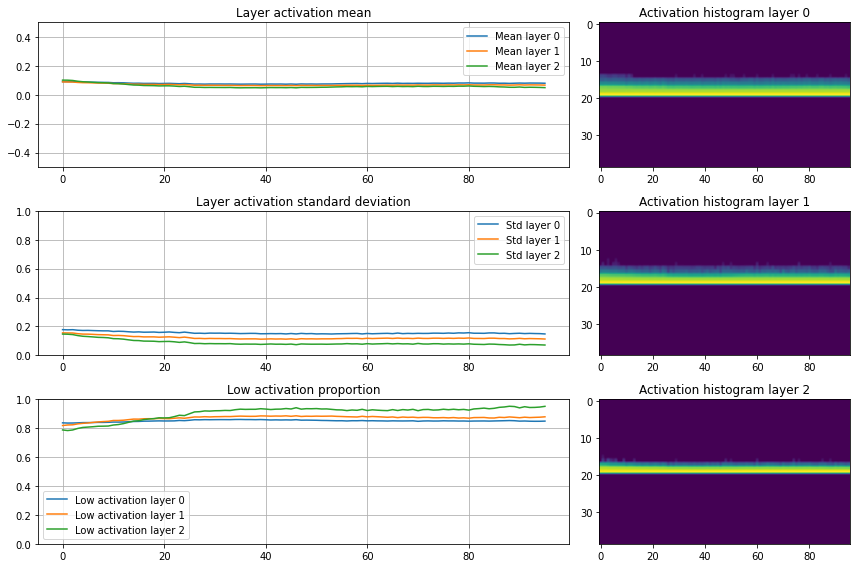

In [45]:
# Train for a few steps to collect the activations.
agent = solve_env(env_args, agent_args, 1, 1024, [LayerActivationMonitoring()], init_func=register_hooks)

# Plot statistics.
plotting.plot_activations(agent.policy.features_extractor.hooks)

We notice at the beginning of the training phase several potential issues. First, the variance of the output of each layer is very close to zero and there is a noticeable decrease between the first and the last layer. Also, almost all the outputs are near zero which can be seen both on the graph showing the proportion of small activations over time and the activation histogram.

In addition to using LeakyReLU instead of ReLU and following FastAI's recommendation, we will perform two changes:

1. Use Kaiming initialization
2. Use some normalization (layer norm in our case)

In [14]:
def init_net(m: nn.Module):
    if len(m._modules) > 0:
        for subm in m._modules:
            init_net(m._modules[subm])
    elif isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(
            m.weight, 
            a=0.1,         # Same as the leakiness parameter for LeakyReLu.
            mode='fan_in', # Preserves magnitude in the forward pass.
            nonlinearity='leaky_relu')

<div id=normalization></div>

## Normalization

To add layer normalization, we need to redefine a model. We will then tell stable-baselines to use our customized model instead of the default one. For the sake of brevity, sizes for the different layers of our model have been hardcoded.

In [47]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 128, **kwargs):
        super().__init__(observation_space, features_dim)

        self.cnn = nn.Sequential(
            nn.LayerNorm([3, 100, 156]),
            
            nn.Conv2d(3, 32, kernel_size=8, stride=4, padding=0, bias=False),
            nn.LayerNorm([32, 24, 38]),
            nn.LeakyReLU(**kwargs),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0, bias=False),
            nn.LayerNorm([64, 11, 18]),
            nn.LeakyReLU(**kwargs),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0, bias=False),
            nn.LayerNorm([64, 9, 16]),
            nn.LeakyReLU(**kwargs),
            
            nn.Flatten(),
        )

        self.linear = nn.Sequential(
            nn.Linear(9216, features_dim, bias=False),
            nn.LayerNorm(features_dim),
            nn.LeakyReLU(**kwargs),
        )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

Let's collect some data again but this time using the modified model.

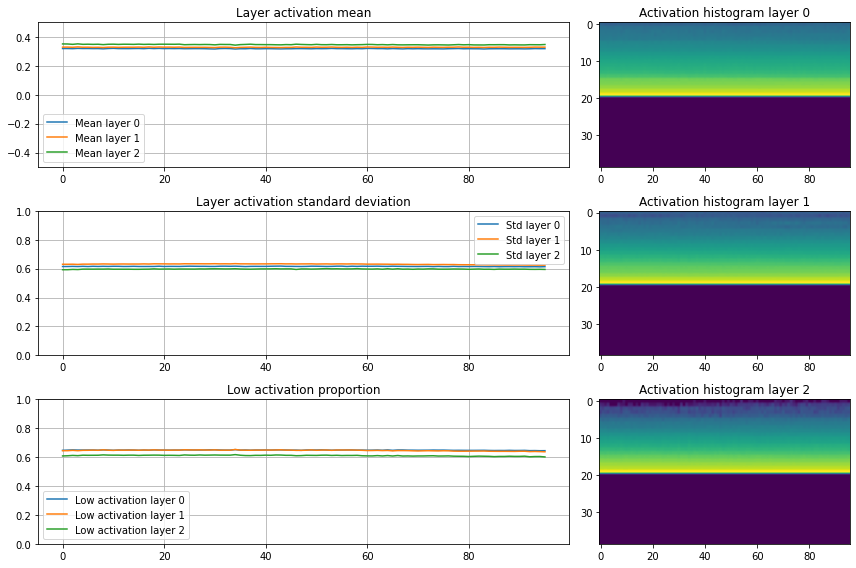

In [50]:
def init_model(model):
    register_hooks(model)
    init_net(model.policy)
    
agent_args['policy_kwargs'] = {'features_extractor_class': CustomCNN}    
agent = solve_env(env_args, agent_args, 1, 1024, [LayerActivationMonitoring()], init_func=init_model)

plotting.plot_activations(agent.policy.features_extractor.hooks)

We notice now that the variance is better behaved, hovering around 0.6. The proportion of activations that are close to zero is significantly lower at ~65% instead of nearly 90% before. In particular, we can notice that the model is now using the full range of the ReLU activation function. 

<div id=norm_comparison></div>

## Comparing the models

The metrics associated with our model look much better now. But does this translate into better performance? In FastAI example, adding normalization was the most impactful factor in improving the results. To see whether we get similar benefits in our setup, let's solve the more difficult variable variant of "defend the center" with different parameters: no normalization, layer normalization and batch normalization. In the plot below, each line is the average of 6 consecutive trials. The coloured region denotes the error mean: $ \frac{\sigma}{\sqrt{n}}$.

Unfortunately, although our modified model exhibits nicer telemetry, it seems to have very little impact on the training performance. We will keep the changes nonetheless since we know they help with the fundamentals.

![Comparison normalization](figures/comparison_norm.png)

Finally, here is the final setup to train against the more difficult verion of "defend the center". It includes the modified architecture with layer normalization as well as the layer activation monitoring callback that will periodically save to tensorboard. To reach satisfactory results in this more difficult environment, you will need to let the agent train for roughly 500k steps.

In [ ]:
env_args = {
    'scenario': 'defend_the_center_relaxed', 
    'frame_skip': 4, 
    'frame_processor': frame_processor
}

agent_args = {
    'n_epochs': 3,
    'n_steps': 4096,
    'learning_rate': 1e-4,
    'batch_size': 32,
    'policy_kwargs': {'features_extractor_class': CustomCNN}
}

agent = solve_env(env_args, 
                  agent_args, 
                  n_envs=2, 
                  timesteps=500000, 
                  callbacks=[LayerActivationMonitoring()], 
                  eval_freq=4096, 
                  init_func=init_model)

<div id=part_3></div>

# [^](#top) Part 3 - Playing against bots 

<div id=deathmatch_presentation></div>

## Scenario presentation

We are now ready to tackle the task of playing Doom deathmatch against programmed bots! To play in deathmatch mode, we need a proper map with items like ammunition, health and respawn points. Using [Slade](https://slade.mancubus.net/index.php?page=about), I created a simple map to train the agent on. It is designed to be easy to navigate through while still requiring some movement to find ennemies. There are 10 spawn points, several ammunition and health items. Players can increase their firepower by picking up one of the four shotguns scattered across the map. The map is contained in the `bots_deathmatch_v1.wad`, next to the corresponding `bots_deathmatch_v1.cfg` scenario config.

A game of deatchmatch consists in a session of 2:30 minutes during which 8 bots in addition of our agent will fight against each other in order to get the most frags. A "frag" corresponds to an enemy killed. Each player starts with a pistol and a couple of second of invicinbility. As soon as the agent dies, it is respawned at one of the respawn point picked uniformly at random. The actions available are the same as the difficul variant of "defend the center". That is, the agent can move, turn and shoot according to the rules we defined earlier. 

The rewards here will be directly obtained from the frags obtained by the agent: 1 frag = 1 point. Note that in the case of a suicide (which can happen when using rocket launchers for example), the frag count will decrease by one. Conveniently, this will work as a penalty to discourage the agent of ending with such outcomes.

![Map presentation](figures/flatmap.png)

<div id=deathmatch_environment></div>

## Modified environment

Setting up a deathmatch game requires a slightly different config for VizDoom as we need to tell it to launch a host for the multiplayer game with a couple of multiplayer-specific parameters.

We also need to adapt the environment wrapper to handle bots and the deathmatch mechanics. In particular, we need to keep track of the "frags" obtained by our agent as this constitutes our reward basis. 

The cell below shows how we can adapt the environment wrapper developped so far to make it compatible for a deathmatch game. The code is pretty self-explanatory. Notice how we redefine the action space in the constructor using the button combinations. Also, to add and remove bots we use the `send_game_command` from the VizDoom game instance.

**Important note: for the following to work, you will need to have the `bots.cfg` file in the same directory as the one used for execution (the notebook in this case). Otherwise, adding bots will have no effect!**

In [10]:
from gym import spaces
from vizdoom.vizdoom import GameVariable

class DoomWithBots(envs.DoomEnv):

    def __init__(self, game, frame_processor, frame_skip, n_bots):
        super().__init__(game, frame_processor, frame_skip)
        self.n_bots = n_bots
        self.last_frags = 0    
        self._reset_bots()
        
        # Redefine the action space using combinations.
        self.possible_actions = get_available_actions(np.array(game.get_available_buttons()))
        self.action_space = spaces.Discrete(len(possible_actions))

    def step(self, action):
        self.game.make_action(self.possible_actions[action], self.frame_skip)
       
        # Compute rewards.
        frags = self.game.get_game_variable(GameVariable.FRAGCOUNT)
        reward = frags - self.last_frags
        self.last_frags = frags

        # Check for episode end.
        self._respawn_if_dead()
        done = self.game.is_episode_finished()
        self.state = self._get_frame(done)

        return self.state, reward, done, {}

    def reset(self):
        self._reset_bots()
        self.last_frags = 0

        return super().reset()

    def _respawn_if_dead(self):
        if not self.game.is_episode_finished():
            if self.game.is_player_dead():
                self.game.respawn_player()
                
    def _reset_bots(self):
        # Make sure you have the bots.cfg file next to the program entry point.
        self.game.send_game_command('removebots')
        for i in range(self.n_bots):
            self.game.send_game_command('addbot')

The other adaptation required is to pass several game arguments via the `add_game_args` function when creating the actual VizDoom game instance. We also redefine the function creating vectorized environments so that it uses the newly defined wrapper. 

In [16]:
from stable_baselines3.common.vec_env import VecTransposeImage, SubprocVecEnv

def env_with_bots(scenario, **kwargs) -> envs.DoomEnv:
    # Create a VizDoom instance.
    game = vizdoom.DoomGame()
    game.load_config(f'scenarios/{scenario}.cfg')
    game.add_game_args('-host 1'              # Game will start after one player connects (our bot).
                       'deathmatch'           # Game mode.
                       '+cl_run 1'            # By default the agent runs (instead of walking).
                       '+name AGENT' 
                       '+sv_forcerespawn 1'   # Agent automatically respawns.
                       '+sv_respawnprotect 1' # Couple of seconds on invicibility after respawning.
                       '+sv_nocrouch 1')      # Players can't crouch.
    game.init()

    return DoomWithBots(game, **kwargs)

def vec_env_with_bots(n_envs=1, **kwargs) -> vec_env.VecTransposeImage:
    return VecTransposeImage(SubprocVecEnv([lambda: env_with_bots(**kwargs)] * n_envs))

NameError: name 'vec_env' is not defined

And that's it, we have all the elements required to play Doom deathmatch! Let us define one final time the environment and agent arguments and launch the training process using our latest model.

Training an agent to play deathmatch is significantly harder than the previous scenarios we have tried so far. We will need to be patient and train for a long time.

In [12]:
# Define new environment parameters.
env_args = {
    'scenario': 'deathmatch_simple',
    'frame_skip': 4,
    'frame_processor': frame_processor,
}

# Defines new agent parameters.
agent_args = {
    'n_epochs': 3,
    'n_steps': 4096,
    'learning_rate': 1e-4,
    'batch_size': 32,
    'policy_kwargs': {'features_extractor_class': CustomCNN}
}

# Try solving the deathmatch scenario.
agent = solve_env(env_args, 
                  agent_args, 
                  n_envs=4, 
                  timesteps=2000000, 
                  callbacks=[LayerActivationMonitoring()], 
                  eval_freq=8192, 
                  init_func=init_model)

So, how did the agent perform? Plotting the average reward over time depicts a tragic situation: although there seems to be some improvement over time, the performance of our model is really not great. Even after 2 million steps the agent barely reaches 2 frags per match on average. Compare that to the best bot which has around 13 frags at the end of each game and our objective seem still pretty far away.

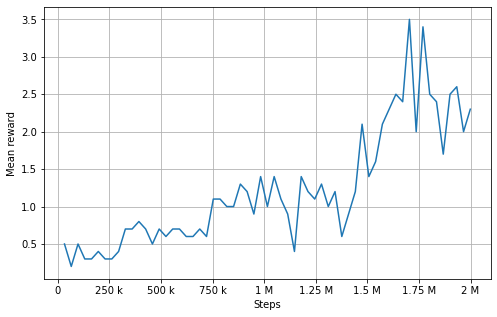

In [27]:
plotting.plot_evaluation_results('logs/evaluations/deathmatch_simple/evaluations.npz')

<div id=deathmatch_discussion></div>

# Discussion

So the learning process did not go as smoothly as one could have expected. Why is that?

The issue lies in the fact that the rewards are very sparse. In other words, only a few combinations of state and action generate useful signals that our agent can use for learning. Indeed, to obtain a frag, the agent has to perform several steps "just right". It has to move and track ennemies, repeatedly shoot them until eventually their health reaches zero.

The way to solve this issue is by means of "reward shaping". The idea is simple: give small positive reward to action that we believe will help towards our main objective of obtaining frags. For example, we can give rewards proportional to damage inflicted to ennemies or proportional to the ammo and health collected.

Another option to help with the learning process is to design some learning curriculum. The idea here is to simplify the task early in the learning process and gradually increase the difficulty. For example, we could reduce the speed and the health of ennemies to make it easier for our agent to obtain positive rewards.

We will implement these ideas in the next part of this series to get much better results so stay tuned!